In [36]:
import os,sys
from importlib import reload
sys.path.append("../tracker")
    
import numpy as np
import scipy as sp
from scipy import constants
from pylab import *
import joblib

In [2]:
import kalmanfilter as KF
import utilities as Util

In [3]:
# Generated toy hits
N_events=5000

Hit_collection={}
Truth_collection ={}
ParTruth_collection={}

for i in range(N_events):
    Hit_collection[i],Truth_collection[i],ParTruth_collection[i] = \
            Util.hit.gen_hits(x0=0,y0=0,z0=0, t0=0, Ax=0.3,Az=0.2,At=1/30,  N_LAYERS=4)

### Check the result of one event with Kalman/LS

Kalman result [Ax, Az, At]: [22.52014246530598, 15.760786331273266, 2.7814000682184883, 0.3097411512104742, 0.19557409522690605, 0.03328430224279506]
LS fit result [Ax, Az, At]: [22.5173297  15.76187778  2.77995301  0.30973493  0.19558974  0.03327731]


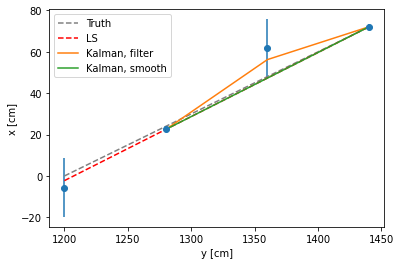

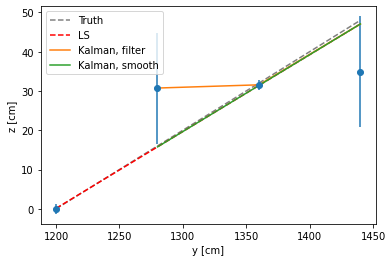

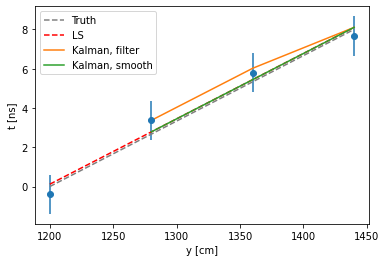

In [4]:
hits = Hit_collection[4]
hits_truth = Truth_collection[0]

# Run Kalman filter
kf = Util.track.run_kf(hits)
# Run LS fit
guess = Util.track.guess_track(hits)
fit_ls = Util.track.fit_track(hits,guess)

print(f"Kalman result [Ax, Az, At]: {fit_ls.values[:]}")
print(f"LS fit result [Ax, Az, At]: {kf.Xsm[0][:]}")

# Digitized hit
hit_x = [hit.x for hit in hits]
hit_y = [hit.y for hit in hits]
hit_z = [hit.z for hit in hits]
hit_t = [hit.t for hit in hits]
hit_x_err = [hit.x_err for hit in hits]
hit_y_err = [hit.y_err for hit in hits]
hit_z_err = [hit.z_err for hit in hits]
hit_t_err = [hit.t_err for hit in hits]

# Truth
hit_truth_x = np.array([hit.x for hit in hits_truth])
hit_truth_y = np.array([hit.y for hit in hits_truth])
hit_truth_z = np.array([hit.z for hit in hits_truth])
hit_truth_t = np.array([hit.t for hit in hits_truth])


# Kalman-Filtred
fit_x = [hit[0] for hit in kf.Xf]
fit_z = [hit[1] for hit in kf.Xf]
fit_t = [hit[2] for hit in kf.Xf]

# Kalman-Smoothed
smooth_x = [hit[0] for hit in kf.Xsm]
smooth_z = [hit[1] for hit in kf.Xsm]
smooth_t = [hit[2] for hit in kf.Xsm]

# LS fit
fit1_res = list(fit_ls.values)
fit_ls_x = fit1_res[0]+fit1_res[3]*(hit_truth_y-hits[1].y)
fit_ls_z = fit1_res[1]+fit1_res[4]*(hit_truth_y-hits[1].y)
fit_ls_t = fit1_res[2]+fit1_res[5]*(hit_truth_y-hits[1].y)




errorbar(hit_y, hit_x, yerr=hit_x_err, fmt="o")
plot(hit_truth_y, hit_truth_x, color="grey", linestyle="--", label="Truth")
plot(hit_truth_y, fit_ls_x,    color="r", linestyle="--", label="LS")
plot(hit_y[1:], fit_x, label="Kalman, filter")
plot(hit_y[1:], smooth_x, label="Kalman, smooth")
xlabel("y [cm]")
ylabel("x [cm]")
legend()
show()

errorbar(hit_y, hit_z, yerr=hit_z_err, fmt="o")
plot(hit_truth_y, hit_truth_z, color="grey", linestyle="--", label="Truth")
plot(hit_truth_y, fit_ls_z,    color="r", linestyle="--", label="LS")
plot(hit_y[1:], fit_z, label="Kalman, filter")
plot(hit_y[1:], smooth_z, label="Kalman, smooth")
xlabel("y [cm]")
ylabel("z [cm]")
legend()
show()

errorbar(hit_y, hit_t, yerr=hit_t_err, fmt="o")
plot(hit_truth_y, hit_truth_t, color="grey", linestyle="--", label="Truth")
plot(hit_truth_y, fit_ls_t,    color="r", linestyle="--", label="LS")
plot(hit_y[1:], fit_t, label="Kalman, filter")
plot(hit_y[1:], smooth_t, label="Kalman, smooth")
xlabel("y [cm]")
ylabel("t [ns]")
legend()
show()

In [9]:
# Performance difference
%timeit -n 10 kf = Util.track.run_kf(hits)
%timeit -n 10 fit_ls = Util.track.fit_track(hits,guess)

229 µs ± 46.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.87 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Run more events

In [ ]:
results={}
results["hits_truth"]=[]
results["kf_popt"]=[]
results["kf_perr"]=[]
results["kf_chi2"]=[]
results["ls_popt"]=[]
results["ls_perr"]=[]
results["ls_chi2"]=[]

# for i in range(len(Hit_collection)):
for i in range(1000):
    # Get one event
    hits = Hit_collection[i]
    hits_truth = ParTruth_collection[i]
    results["hits_truth"].append(hits_truth)
    dof = 3*len(hits)-6
    
    
    # Run Kalman filter
    kf = Util.track.run_kf(hits)
    # Run LS fit
    guess = Util.track.guess_track(hits)
    fit1 = Util.track.fit_track(hits,guess)
    
    
    results["kf_popt"].append(kf.Xsm[0])
    results["kf_perr"].append(np.sqrt(np.diag(kf.Csm[0])))
    results["kf_chi2"].append(kf.chift_total)
    
    
    lsfit_values = [fit1.values[0],fit1.values[1],fit1.values[2],fit1.values[3],fit1.values[4],fit1.values[5]]
    lsfit_errors = [fit1.errors[0],fit1.errors[1],fit1.errors[2],fit1.errors[3],fit1.errors[4],fit1.errors[5]]
    results["ls_popt"].append(lsfit_values)
    results["ls_perr"].append(lsfit_errors)
    results["ls_chi2"].append(fit1.fval)

for key in results:
    results[key] = np.array(results[key])

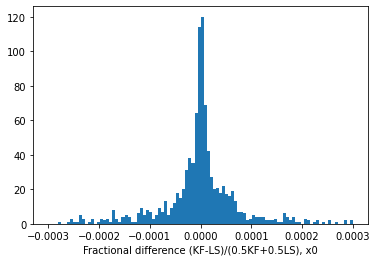

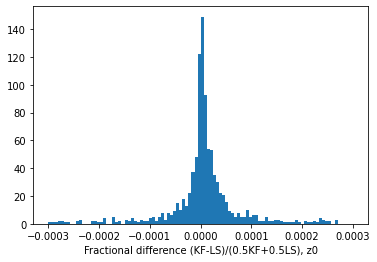

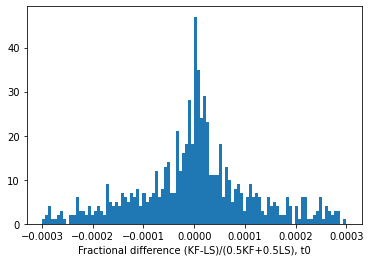

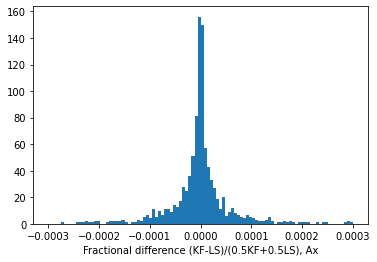

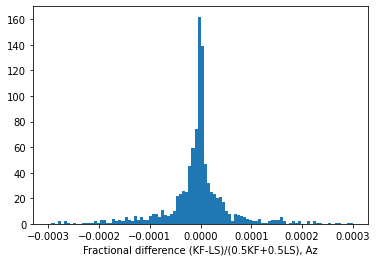

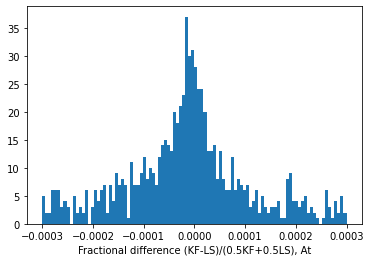

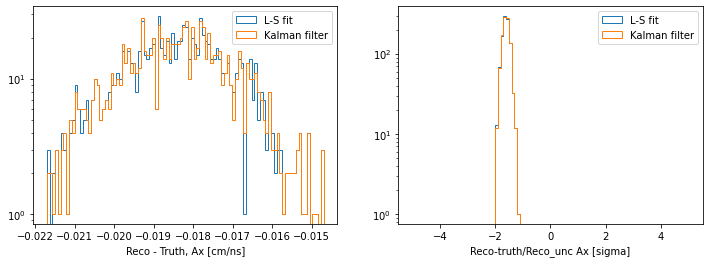

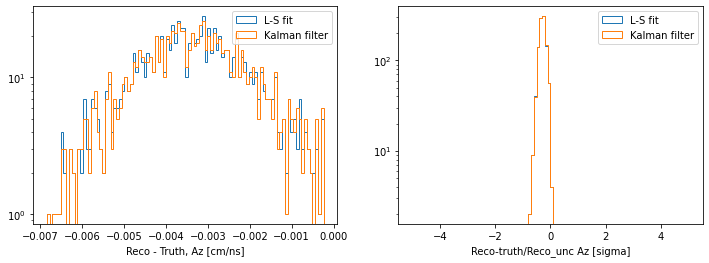

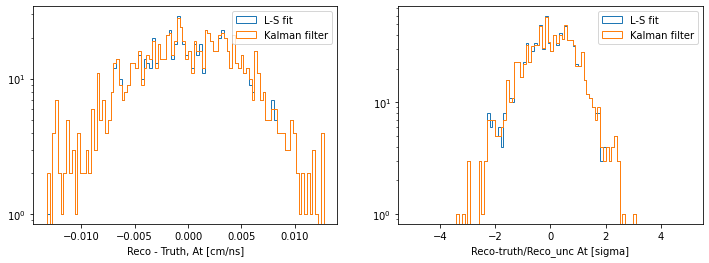

In [ ]:
par_names=['x0','z0', 't0',  'Ax', 'Az', 'At'] # Use real world direction
par_unit= ["[cm]","[cm]",'[ns]',"[cm/ns]","[cm/ns]","[cm/ns]"]
# ranges=[(-20,20),(-20,20),(-20,20),(-20,20),(-30,30),(-30,30),(-30,30)]

for ipar in range(6):
    diff=results["kf_popt"][:,ipar] - results["ls_popt"][:,ipar]
    avg =0.5*(results["kf_popt"][:,ipar] + results["ls_popt"][:,ipar])
    hist(diff/avg,bins=100,range=(-0.0003,0.0003))
    xlabel(f"Fractional difference (KF-LS)/(0.5KF+0.5LS), {par_names[ipar]}")
#     title()

    show()

for ipar in range(3,6):
    #_range=ranges[ipar]
    residual_km=results["kf_popt"][:,ipar]-results["hits_truth"][:,ipar]
    residual_ls=results["ls_popt"][:,ipar]-results["hits_truth"][:,ipar]
    _range=(np.percentile(residual_km,1),np.percentile(residual_km,99))
    
    def pull(x_measure, x_truth, x_unc):
        return (x_measure-x_truth)/x_unc
    pull_ls=pull(residual_ls,0,results["ls_perr"][:,ipar])
    pull_km=pull(residual_km,0,results["kf_perr"][:,ipar])
    
    fig,axs=plt.subplots(1,2,figsize=(12,4))
    plt.sca(axs[0])
    plt.hist(residual_ls,histtype="step",bins=100,range=_range,label="L-S fit");#bins=np.linspace(360,500,100));
    plt.hist(residual_km,histtype="step",bins=100,range=_range,label="Kalman filter");#bins=np.linspace(360,500,100));
    plt.legend()
    plt.xlabel(f"Reco - Truth, {par_names[ipar]} {par_unit[ipar]}")
    plt.yscale("log")
    plt.sca(axs[1])
    plt.hist(pull_ls,histtype="step",bins=100,range=(-5,5),label="L-S fit");#bins=np.linspace(360,500,100));
    plt.hist(pull_km,histtype="step",bins=100,range=(-5,5),label="Kalman filter");#bins=np.linspace(360,500,100));
    plt.legend()
    plt.xlabel(f"Reco-truth/Reco_unc {par_names[ipar]} [sigma]")
    plt.yscale("log")    
    
    
    plt.show()

## Run on an event that failed in the tracker

In [29]:
x = [241.62934581783023, 259.25, 221.49664808213277, 227.75]
y = [9894.0, 9975.599999999999, 10057.2, 10138.8]
z = [12456.75, 12450.5, 12461.25, 12450.5]
t = [40.91365706617539, 45.79668867914941, 48.189471653643565, 50.295569678622876]
layers = [0,1,2,3,]

hits = Util.hit.make_hits(x,y,z,t,layers)

In [39]:
reload(Util)
reload(KF)

<module 'kalmanfilter' from '../tracker\\kalmanfilter.py'>

Kalman result [Ax, Az, At]: [-943.3044087464077, 13312.732953684885, 52.91610291726607, 0.0006360513732577289, 2.372189293722675, 0.08931341102332853]
LS fit result [Ax, Az, At]: [-9.43304651e+02  1.33127328e+04  5.29162854e+01  6.36116294e-04
  2.37218972e+00  8.93120322e-02]
Kalman filter chi2 [0, 1.0115026096576591, 0.7194745110612728]
Kalman smoother chi2 [1.1189297302406063, 0.2468587287178552, 0]


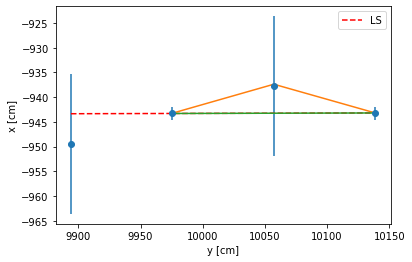

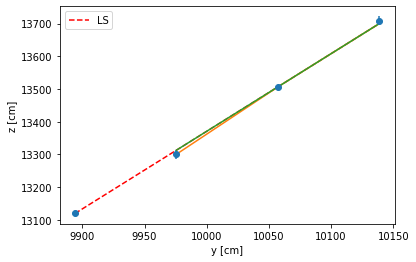

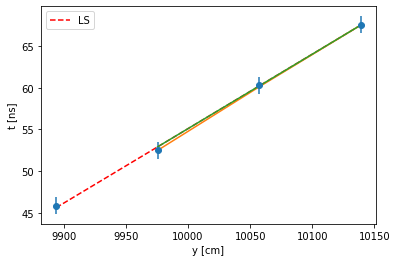

In [40]:
# hits = Hit_collection[4]
# hits_truth = Truth_collection[0]

# Run Kalman filter
kf = Util.track.run_kf(hits, multiple_scattering=False)
# kf = Util.track.run_kf(hits, multiple_scattering=True)
# Run LS fit
guess = Util.track.guess_track(hits)
fit_ls = Util.track.fit_track(hits,guess)

print(f"Kalman result [Ax, Az, At]: {fit_ls.values[:]}")
print(f"LS fit result [Ax, Az, At]: {kf.Xsm[0][:]}")

print("Kalman filter chi2", kf.chift)
print("Kalman smoother chi2", kf.chism)

# Digitized hit
hit_x = [hit.x for hit in hits]
hit_y = [hit.y for hit in hits]
hit_z = [hit.z for hit in hits]
hit_t = [hit.t for hit in hits]
hit_x_err = [hit.x_err for hit in hits]
hit_y_err = [hit.y_err for hit in hits]
hit_z_err = [hit.z_err for hit in hits]
hit_t_err = [hit.t_err for hit in hits]

# Truth
# hit_truth_x = np.array([hit.x for hit in hits_truth])
hit_truth_y = np.array(hit_y)
# hit_truth_z = np.array([hit.z for hit in hits_truth])
# hit_truth_t = np.array([hit.t for hit in hits_truth])


# Kalman-Filtred
fit_x = [hit[0] for hit in kf.Xf]
fit_z = [hit[1] for hit in kf.Xf]
fit_t = [hit[2] for hit in kf.Xf]

# Kalman-Smoothed
smooth_x = [hit[0] for hit in kf.Xsm]
smooth_z = [hit[1] for hit in kf.Xsm]
smooth_t = [hit[2] for hit in kf.Xsm]

# LS fit
fit1_res = list(fit_ls.values)
fit_ls_x = fit1_res[0]+fit1_res[3]*(hit_truth_y-hits[1].y)
fit_ls_z = fit1_res[1]+fit1_res[4]*(hit_truth_y-hits[1].y)
fit_ls_t = fit1_res[2]+fit1_res[5]*(hit_truth_y-hits[1].y)




errorbar(hit_y, hit_x, yerr=hit_x_err, fmt="o")
plot(hit_truth_y, fit_ls_x,    color="r", linestyle="--", label="LS")
plot(hit_y[1:], fit_x)
plot(hit_y[1:], smooth_x)
xlabel("y [cm]")
ylabel("x [cm]")
legend()
show()

errorbar(hit_y, hit_z, yerr=hit_z_err, fmt="o")
plot(hit_truth_y, fit_ls_z,    color="r", linestyle="--", label="LS")
plot(hit_y[1:], fit_z)
plot(hit_y[1:], smooth_z)
xlabel("y [cm]")
ylabel("z [cm]")
legend()
show()

errorbar(hit_y, hit_t, yerr=hit_t_err, fmt="o")
plot(hit_truth_y, fit_ls_t,    color="r", linestyle="--", label="LS")
plot(hit_y[1:], fit_t)
plot(hit_y[1:], smooth_t)
xlabel("y [cm]")
ylabel("t [ns]")
legend()
show()

In [20]:
sin_theta=0.8

In [21]:
L_Al =  0.6
L_Sc = 1.0 # [cm] Scintillator
L_r_Al = 24.0111/2.7; # [cm] Radiation length Aluminum/ density of Aluminum
L_r_Sc = 43; # [cm] Radiation length Scintillator (Saint-Gobain paper)

L_rad = L_Al / L_r_Al + L_Sc / L_r_Sc; # [rad lengths] orthogonal to Layer
L_rad /= sin_theta; # [rad lengths] in direction of track

sigma_ms = 13.6 * np.sqrt(L_rad) * (1 + 0.038 * np.log(L_rad)); #
sigma_ms /= 500 # [MeV] Divided by 500 MeV

# Q = Q * np.power(sigma_ms, 2); # Scattering contribution to process noise

In [42]:
# tracks=joblib.load("hits_example_group.joblib")
# hits=tracks[59]
hits=joblib.load("hits_example.joblib")

In [44]:
import trackfinder as TF